<a href="https://colab.research.google.com/github/gulabpatel/NLP_BERT/blob/main/10%3A%20Classification_BERT_DistillBert_ALBERT_RoBERTa_XNNet_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading, EDA & Preprocessing

In [ ]:
## Installing Simple Transformers
!pip install simpletransformers

In [ ]:
## Read Data
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.utils import class_weight

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset/tripadvisor_hotel_reviews.csv")
df.sample(10)

## EDA and Prep Data for SimpleTransformers

In [ ]:
df["Review"] = df["Review"].apply(lambda x: x.replace("* ", ""))
df["Review"] = df["Review"].apply(lambda x: x.replace("__Ç_é_", "s"))
df["Review"] = df["Review"].apply(lambda x: x.replace("__Ç", "s"))
df["Review"] = df["Review"].apply(lambda x: x.replace("///", " "))

In [ ]:
# Rename 'sentence' column to 'text' (this is the name SimpleTransformers expects).
df.columns = ['text', 'label']

Tramsformer assumes label from 0 to Num_labels.

In [ ]:
# Dict={1:0,2:1,3:2,4:3,5:4}
# df['label']=df['label'].map(Dict)
df['label'] = df['label'].apply(lambda x:x-1)

## EDA

Check Missing values

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

Check calss imbalancy

In [ ]:
df.label.value_counts()

4    9054
3    6039
2    2184
1    1793
0    1421
Name: label, dtype: int64

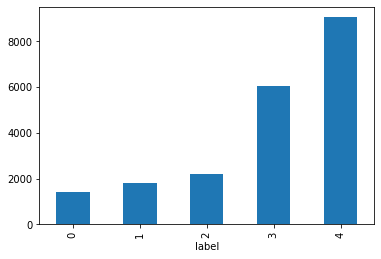

In [ ]:
df.groupby("label").size().plot.bar()

Data is imbalance, let's calculate the class_weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df.label), y= df.label)

Split off 80-10-10% for Training, validation and Testing.


In [ ]:
# Use 80% for training and 10% for validation and 10% for testing.
train_df, val_df = train_test_split(df, random_state=2018, test_size=0.2)
validation_df, test_df = train_test_split(val_df, random_state=2018, test_size=0.5)

print("train_df size : ", len(train_df))
print("validation_df size : ", len(validation_df))
print("test_df size : ", len(test_df))

train_df size :  16392
validation_df size :  2049
test_df size :  2050


# Model 1 Bert(bert base uncased)


reprocess_input_data: bool
If True, the input data will be reprocessed even if a cached file of the input data exists in the cache_dir.

supported models https://simpletransformers.ai/docs/classification-specifics/#supported-model-types

In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

model = ClassificationModel('bert', 'bert-base-uncased', num_labels=5, args=args)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Inspect Training Arguments

Retrieves all of the arguments and their values, and prints them in a table.


In [ ]:
arg_values = []
pd.set_option('display.max_rows', 80)

# For all of the arguments...
for arg in dir(model.args):
    
    # Skip over the special attributes and any functions.
    if (not arg[0:2] == '__') and (not callable(getattr(model.args, arg))):
    
        # Store the argument and its value as a tuple.
        arg_values.append((arg, str(getattr(model.args, arg))))

# Store as a dataframe just to get the pretty printout.
df_args = pd.DataFrame(arg_values)        

df_args

,0,1
0,adafactor_beta1,None
1,adafactor_clip_threshold,1.0
2,adafactor_decay_rate,-0.8
3,adafactor_eps,"(1e-30, 0.001)"
4,adafactor_relative_step,True
...,...,...
90,wandb_kwargs,{}
91,wandb_project,None
92,warmup_ratio,0.06
93,warmup_steps,0


### Most Important Arguments

Let's check the default parameters

In [ ]:
print("train epochs : ", model.args.num_train_epochs)
print("max_seq_length : ", model.args.max_seq_length)
print("train_batch_size : ", model.args.train_batch_size)
print("learning_rate : ", model.args.learning_rate)
print("model_name : ", model.args.model_name)

train epochs :  1
max_seq_length :  128
train_batch_size :  8
learning_rate :  4e-05
model_name :  bert-base-uncased


### Choose Hyperparameters

In [ ]:
# These are the values we used in our Notebook:
model.args.num_train_epochs = 4
model.args.max_seq_length = 128
model.args.train_batch_size = 32
model.args.learning_rate = 2e-5

### Configure Validation

Periodically evaluate on our 10% validation set during training to monitor over-fitting.

Calculate number of steps so we can specify how often to evaluate.

In [ ]:
# Run evaluation periodically during training to monitor progress.
model.args.evaluate_during_training = True

# "Print results from evaluation during training."
model.args.evaluate_during_training_verbose = True

# "Perform evaluation at every specified steps.Checkpoint model and the evaluation results will be saved."
model.args.evaluate_during_training_steps = 120

# We only need to tokenize our validation set once, then we can read it from the cache.
model.args.use_cached_eval_features = True

### Configure Early Stopping

There's a nice intro to early stopping in their docs here:
    
* https://simpletransformers.ai/docs/usage/#using-early-stopping



In [ ]:
# Turn on early stopping.
model.args.use_early_stopping = True
model.args.early_stopping_delta = 0.01
model.args.early_stopping_metric = "eval_loss"
model.args.early_stopping_metric_minimize = True
# "Terminate training after this many evaluations without an improvement in the
#  evaluation metric greater then early_stopping_delta."
model.args.early_stopping_patience = 2


##Train

In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 16,392 samples...


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/16392 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/513 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2049 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/simpletransformers/classi

Running Epoch 1 of 4:   0%|          | 0/513 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


## Evaluate on Test Set


In [ ]:
model = ClassificationModel(
    "bert", "outputs/best_model"
)

**On Validation Set**

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def conf_matrix(labels, preds):
    return confusion_matrix(labels, preds)

def class_report(labels, preds):
    return classification_report(labels, preds, output_dict=True)
    
result, val_outputs, wrong_predictions = model.eval_model(validation_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score, clf_report = class_report)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.49195203202937837, 'f1': 0.6500732064421669, 'cm': array([[ 94,  30,   5,   1,   1],
       [ 44,  64,  63,  16,   3],
       [  6,  17, 114,  78,   6],
       [  0,   2,  49, 344, 202],
       [  0,   1,   8, 185, 716]]), 'acc': 0.6500732064421669, 'clf_report': {'0.0': {'precision': 0.6527777777777778, 'recall': 0.7175572519083969, 'f1-score': 0.6836363636363636, 'support': 131}, '1.0': {'precision': 0.5614035087719298, 'recall': 0.3368421052631579, 'f1-score': 0.4210526315789474, 'support': 190}, '2.0': {'precision': 0.4769874476987448, 'recall': 0.5158371040723982, 'f1-score': 0.49565217391304356, 'support': 221}, '3.0': {'precision': 0.5512820512820513, 'recall': 0.576214405360134, 'f1-score': 0.5634725634725636, 'support': 597}, '4.0': {'precision': 0.771551724137931, 'recall': 0.7868131868131868, 'f1-score': 0.7791077257889011, 'support': 910}, 'accuracy': 0.6500732064421669, 'macro avg': {'precision': 0.602800501933687, 'recall': 0.5866528106834548, 'f1-score': 0.5885

**On Test Set**

In [ ]:
result, test_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score, clf_report = class_report)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.49195203202937837, 'f1': 0.6500732064421669, 'cm': array([[ 94,  30,   5,   1,   1],
       [ 44,  64,  63,  16,   3],
       [  6,  17, 114,  78,   6],
       [  0,   2,  49, 344, 202],
       [  0,   1,   8, 185, 716]]), 'acc': 0.6500732064421669, 'clf_report': {'0.0': {'precision': 0.6527777777777778, 'recall': 0.7175572519083969, 'f1-score': 0.6836363636363636, 'support': 131}, '1.0': {'precision': 0.5614035087719298, 'recall': 0.3368421052631579, 'f1-score': 0.4210526315789474, 'support': 190}, '2.0': {'precision': 0.4769874476987448, 'recall': 0.5158371040723982, 'f1-score': 0.49565217391304356, 'support': 221}, '3.0': {'precision': 0.5512820512820513, 'recall': 0.576214405360134, 'f1-score': 0.5634725634725636, 'support': 597}, '4.0': {'precision': 0.771551724137931, 'recall': 0.7868131868131868, 'f1-score': 0.7791077257889011, 'support': 910}, 'accuracy': 0.6500732064421669, 'macro avg': {'precision': 0.602800501933687, 'recall': 0.5866528106834548, 'f1-score': 0.5885

result  {'mcc': 0.49468331260672477, 'eval_loss': 0.775075949583536}

##  Over-Fitting 

In [ ]:
import pandas as pd
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.read_csv("/content/outputs/training_progress_scores.csv")

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('global_step')
df_stats

,train_loss,mcc,eval_loss
global_step,,,
120,1.24,0.25,1.17
240,0.83,0.44,0.86
360,1.06,0.43,0.85
480,0.85,0.49,0.79
513,0.84,0.49,0.78
600,0.73,0.49,0.79
720,0.72,0.49,0.79
840,1.17,0.50,0.78


Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

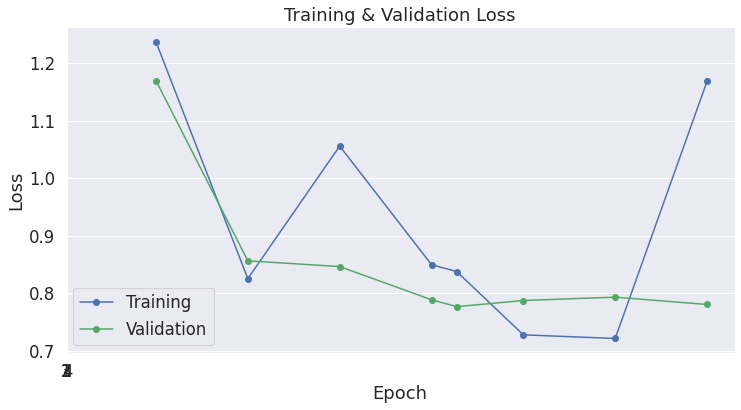

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['train_loss'], 'b-o', label="Training")
plt.plot(df_stats['eval_loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# BERT(Handle Class inbalancy)

In [ ]:
class_weights = dict(zip(np.unique(df.label), class_weights))
class_weights

{0: 2.8840253342716395,
 1: 2.2856664807585054,
 2: 1.8764652014652015,
 3: 0.678622288458354,
 4: 0.45263971725204327}

In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

model = ClassificationModel('bert', 'bert-base-uncased', num_labels=5, args=args, weight=[2.88, 2.28, 1.87, 0.68, 0.45])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Inspect Training Arguments

In [ ]:
print("train epochs : ", model.args.num_train_epochs)
print("max_seq_length : ", model.args.max_seq_length)
print("train_batch_size : ", model.args.train_batch_size)
print("learning_rate : ", model.args.learning_rate)
print("model_name : ", model.args.model_name)

train epochs :  1
max_seq_length :  128
train_batch_size :  8
learning_rate :  4e-05
model_name :  bert-base-uncased


In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 16,392 samples...


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/16392 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2049 [00:00<?, ?it/s]

## Model Evaluation


### On Validation

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def conf_matrix(labels, preds):
    return confusion_matrix(labels, preds)
    
result, model_outputs, wrong_predictions = model.eval_model(validation_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2049 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.49005145681030304, 'f1': 0.6412884333821376, 'cm': array([[ 96,  32,   2,   1,   0],
       [ 47,  89,  48,   3,   3],
       [  4,  49, 106,  58,   4],
       [  2,  14,  65, 357, 159],
       [  1,   5,  11, 227, 666]]), 'acc': 0.6412884333821376, 'eval_loss': 0.8688666312611056}


In [ ]:
print(classification_report(validation_df.label,np.argmax(val_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68       131
           1       0.56      0.34      0.42       190
           2       0.48      0.52      0.50       221
           3       0.55      0.58      0.56       597
           4       0.77      0.79      0.78       910

    accuracy                           0.65      2049
   macro avg       0.60      0.59      0.59      2049
weighted avg       0.65      0.65      0.65      2049



### On Test

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score, clf_report = class_report)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2050 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.525265369065681, 'f1': 0.6619512195121952, 'cm': array([[126,  41,   2,   1,   0],
       [ 39,  87,  40,  14,   0],
       [  8,  31, 125,  52,   1],
       [  1,  12,  74, 345, 138],
       [  1,   5,  14, 219, 674]]), 'acc': 0.6619512195121952, 'clf_report': {'0.0': {'precision': 0.72, 'recall': 0.7411764705882353, 'f1-score': 0.7304347826086955, 'support': 170}, '1.0': {'precision': 0.4943181818181818, 'recall': 0.48333333333333334, 'f1-score': 0.4887640449438202, 'support': 180}, '2.0': {'precision': 0.49019607843137253, 'recall': 0.576036866359447, 'f1-score': 0.5296610169491526, 'support': 217}, '3.0': {'precision': 0.5467511885895404, 'recall': 0.6052631578947368, 'f1-score': 0.5745212323064114, 'support': 570}, '4.0': {'precision': 0.8290282902829028, 'recall': 0.7382256297918949, 'f1-score': 0.7809965237543454, 'support': 913}, 'accuracy': 0.6619512195121952, 'macro avg': {'precision': 0.6160587478243995, 'recall': 0.6288070915935295, 'f1-score': 0.620875520112485, 

### On raw text

In [ ]:
predictions, raw_outputs = model.predict([df.text.iloc[5]])
predictions, raw_outputs, np.argmax(raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([4]),
 array([[-2.28515625, -1.69335938, -0.96923828,  1.92871094,  3.77929688]]),
 4)

# DistillBert(Handle Class inbalancy)

In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

model = ClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=5, args=args, weight=[2.88, 2.28, 1.87, 0.68, 0.45])

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Inspect Training Arguments

In [ ]:
print("train epochs : ", model.args.num_train_epochs)
print("max_seq_length : ", model.args.max_seq_length)
print("train_batch_size : ", model.args.train_batch_size)
print("learning_rate : ", model.args.learning_rate)
print("model_name : ", model.args.model_name)

train epochs :  1
max_seq_length :  128
train_batch_size :  8
learning_rate :  4e-05
model_name :  distilbert-base-uncased


In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 16,392 samples...


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/16392 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2049 [00:00<?, ?it/s]

## Model Evaluation


In [ ]:
# model = ClassificationModel(
#     "bert", "outputs/best_model"
# )

### On Validation

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def conf_matrix(labels, preds):
    return confusion_matrix(labels, preds)
    
result, val_outputs, wrong_predictions = model.eval_model(validation_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2049 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.48300126555636014, 'f1': 0.6364080039043436, 'cm': array([[ 97,  31,   3,   0,   0],
       [ 40,  94,  49,   5,   2],
       [  2,  48, 109,  55,   7],
       [  0,  19,  87, 322, 169],
       [  2,   6,  13, 207, 682]]), 'acc': 0.6364080039043436, 'eval_loss': 0.8958661991102687}


In [ ]:
print(classification_report(validation_df.label,np.argmax(val_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       131
           1       0.47      0.49      0.48       190
           2       0.42      0.49      0.45       221
           3       0.55      0.54      0.54       597
           4       0.79      0.75      0.77       910

    accuracy                           0.64      2049
   macro avg       0.58      0.60      0.59      2049
weighted avg       0.64      0.64      0.64      2049



### On Test

In [ ]:
# Evaluate the model
result, test_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2050 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.4927383190101385, 'f1': 0.6390243902439025, 'cm': array([[118,  48,   3,   1,   0],
       [ 35,  96,  35,  14,   0],
       [  5,  43, 111,  56,   2],
       [  1,  15,  86, 314, 154],
       [  2,   5,  19, 216, 671]]), 'acc': 0.6390243902439025, 'eval_loss': 0.8843171392433374}


In [ ]:
print(classification_report(test_df.label,np.argmax(test_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       170
           1       0.46      0.53      0.50       180
           2       0.44      0.51      0.47       217
           3       0.52      0.55      0.54       570
           4       0.81      0.73      0.77       913

    accuracy                           0.64      2050
   macro avg       0.59      0.60      0.60      2050
weighted avg       0.65      0.64      0.65      2050



### On raw text

In [ ]:
predictions, raw_outputs = model.predict([df.text.iloc[5]])
predictions, raw_outputs, np.argmax(raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([4]),
 array([[-2.81054688, -1.96972656, -0.94921875,  1.93554688,  2.92382812]]),
 4)

# Albert(Handle Class inbalancy)


In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

model = ClassificationModel('albert', 'albert-base-v2', num_labels=5, args=args, weight=[2.88, 2.28, 1.87, 0.68, 0.45])

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

## Inspect Training Arguments

In [ ]:
print("train epochs : ", model.args.num_train_epochs)
print("max_seq_length : ", model.args.max_seq_length)
print("train_batch_size : ", model.args.train_batch_size)
print("learning_rate : ", model.args.learning_rate)
print("model_name : ", model.args.model_name)

train epochs :  1
max_seq_length :  128
train_batch_size :  8
learning_rate :  4e-05
model_name :  albert-base-v2


In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 16,392 samples...


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/16392 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2049 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


## Model Evaluation


### On Validation

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def conf_matrix(labels, preds):
    return confusion_matrix(labels, preds)
    
result, val_outputs, wrong_predictions = model.eval_model(validation_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2049 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.38716628377556467, 'f1': 0.570522205954124, 'cm': array([[ 93,  32,   6,   0,   0],
       [ 52,  73,  47,  16,   2],
       [  7,  60,  72,  72,  10],
       [  2,  14,  76, 294, 211],
       [  0,   8,  31, 234, 637]]), 'acc': 0.570522205954124, 'eval_loss': 1.0570328591630616}


In [ ]:
print(classification_report(validation_df.label,np.argmax(val_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       131
           1       0.39      0.38      0.39       190
           2       0.31      0.33      0.32       221
           3       0.48      0.49      0.48       597
           4       0.74      0.70      0.72       910

    accuracy                           0.57      2049
   macro avg       0.50      0.52      0.51      2049
weighted avg       0.58      0.57      0.57      2049



### On Test

In [ ]:
# Evaluate the model
result, test_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2050 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.40282137435463217, 'f1': 0.5770731707317073, 'cm': array([[113,  46,   8,   3,   0],
       [ 42,  85,  27,  26,   0],
       [ 11,  59,  81,  60,   6],
       [  2,  18,  71, 273, 206],
       [  2,   7,  31, 242, 631]]), 'acc': 0.5770731707317073, 'eval_loss': 1.0493019080579513}


In [ ]:
print(classification_report(test_df.label,np.argmax(test_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       170
           1       0.40      0.47      0.43       180
           2       0.37      0.37      0.37       217
           3       0.45      0.48      0.47       570
           4       0.75      0.69      0.72       913

    accuracy                           0.58      2050
   macro avg       0.53      0.54      0.53      2050
weighted avg       0.59      0.58      0.58      2050



### On raw text

In [ ]:
predictions, raw_outputs = model.predict([df.text.iloc[5]])
predictions, raw_outputs, np.argmax(raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([4]),
 array([[-2.58984375, -1.28808594, -0.14978027,  1.83105469,  2.828125  ]]),
 4)

# Roberta(Handle Class inbalancy)


In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

model = ClassificationModel('roberta', 'roberta-base', num_labels=5, args=args, weight=[2.88, 2.28, 1.87, 0.68, 0.45])

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

## Inspect Training Arguments

In [ ]:
print("train epochs : ", model.args.num_train_epochs)
print("max_seq_length : ", model.args.max_seq_length)
print("train_batch_size : ", model.args.train_batch_size)
print("learning_rate : ", model.args.learning_rate)
print("model_name : ", model.args.model_name)

train epochs :  1
max_seq_length :  128
train_batch_size :  8
learning_rate :  4e-05
model_name :  roberta-base


In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 16,392 samples...


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/16392 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2049 [00:00<?, ?it/s]

## Model Evaluation


### On Validation

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def conf_matrix(labels, preds):
    return confusion_matrix(labels, preds)
    
result, val_outputs, wrong_predictions = model.eval_model(validation_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2049 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.2415652139376959, 'f1': 0.4924353343094192, 'cm': array([[ 90,  21,   2,   1,  17],
       [ 68,  31,   7,   0,  84],
       [ 25,  19,   6,   2, 169],
       [  7,  22,   2,   1, 565],
       [  7,  18,   4,   0, 881]]), 'acc': 0.4924353343094192, 'eval_loss': 1.3320476920688198}


In [ ]:
print(classification_report(validation_df.label,np.argmax(val_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.46      0.69      0.55       131
           1       0.28      0.16      0.21       190
           2       0.29      0.03      0.05       221
           3       0.25      0.00      0.00       597
           4       0.51      0.97      0.67       910

    accuracy                           0.49      2049
   macro avg       0.36      0.37      0.30      2049
weighted avg       0.39      0.49      0.36      2049



### On Test

In [ ]:
# Evaluate the model
result, test_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2050 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.26970460566367793, 'f1': 0.5068292682926829, 'cm': array([[119,  27,   4,   1,  19],
       [ 69,  29,   7,   3,  72],
       [ 25,  22,   7,   1, 162],
       [ 11,  17,   3,   1, 538],
       [ 16,  11,   3,   0, 883]]), 'acc': 0.5068292682926829, 'eval_loss': 1.3352248819421701}


In [ ]:
print(classification_report(test_df.label,np.argmax(test_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.50      0.70      0.58       170
           1       0.27      0.16      0.20       180
           2       0.29      0.03      0.06       217
           3       0.17      0.00      0.00       570
           4       0.53      0.97      0.68       913

    accuracy                           0.51      2050
   macro avg       0.35      0.37      0.31      2050
weighted avg       0.38      0.51      0.38      2050



### On raw text

In [ ]:
predictions, raw_outputs = model.predict([df.text.iloc[5]])
predictions, raw_outputs, np.argmax(raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([4]),
 array([[-2.640625  , -0.7265625 ,  0.58496094,  1.16796875,  1.35546875]]),
 4)

# XLNet(Handle Class inbalancy)


In [ ]:
from simpletransformers.classification import ClassificationModel

args = {
    'reprocess_input_data': True, 
    'overwrite_output_dir': True
}

model = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=5, args=args, weight=[2.88, 2.28, 1.87, 0.68, 0.45])

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

## Inspect Training Arguments

In [ ]:
print("train epochs : ", model.args.num_train_epochs)
print("max_seq_length : ", model.args.max_seq_length)
print("train_batch_size : ", model.args.train_batch_size)
print("learning_rate : ", model.args.learning_rate)
print("model_name : ", model.args.model_name)

train epochs :  1
max_seq_length :  128
train_batch_size :  8
learning_rate :  4e-05
model_name :  xlnet-base-cased


In [ ]:
print('Training on {:,} samples...'.format(len(train_df)))

# Train the model, testing against the validation set periodically.
out = model.train_model(train_df, eval_df=validation_df)

Training on 16,392 samples...


/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/16392 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/2049 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


## Model Evaluation


### On Validation

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def conf_matrix(labels, preds):
    return confusion_matrix(labels, preds)
    
result, val_outputs, wrong_predictions = model.eval_model(validation_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2049 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.48638953925640704, 'f1': 0.6408003904343582, 'cm': array([[ 86,  42,   2,   1,   0],
       [ 38, 106,  37,   5,   4],
       [  3,  55, 109,  49,   5],
       [  1,  20,  78, 306, 192],
       [  0,   7,  12, 185, 706]]), 'acc': 0.6408003904343582, 'eval_loss': 0.8973847102910164}


In [ ]:
print(classification_report(validation_df.label,np.argmax(val_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       131
           1       0.46      0.56      0.50       190
           2       0.46      0.49      0.47       221
           3       0.56      0.51      0.54       597
           4       0.78      0.78      0.78       910

    accuracy                           0.64      2049
   macro avg       0.59      0.60      0.59      2049
weighted avg       0.64      0.64      0.64      2049



### On Test

In [ ]:
# Evaluate the model
result, test_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, cm=conf_matrix, acc=accuracy_score)
print(result)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


  0%|          | 0/2050 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/257 [00:00<?, ?it/s]

{'mcc': 0.5151746333765646, 'f1': 0.6580487804878049, 'cm': array([[119,  48,   3,   0,   0],
       [ 25, 114,  26,  14,   1],
       [  7,  46, 108,  50,   6],
       [  1,  19,  79, 297, 174],
       [  2,   9,  10, 181, 711]]), 'acc': 0.6580487804878049, 'eval_loss': 0.8944905155015827}


In [ ]:
print(classification_report(test_df.label,np.argmax(test_outputs,axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       170
           1       0.48      0.63      0.55       180
           2       0.48      0.50      0.49       217
           3       0.55      0.52      0.53       570
           4       0.80      0.78      0.79       913

    accuracy                           0.66      2050
   macro avg       0.62      0.63      0.62      2050
weighted avg       0.66      0.66      0.66      2050



### On raw text

In [ ]:
predictions, raw_outputs = model.predict([df.text.iloc[5]])
predictions, raw_outputs, np.argmax(raw_outputs)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([4]),
 array([[-1.98046875, -1.54199219, -0.68408203,  2.60546875,  4.45703125]]),
 4)

#GPT2

## Installs

In [ ]:
!pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:54tcmalloc: large alloc 1147494400 bytes == 0x3a4f8000 @  0x7f6f3d7a8615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████▌             | 1055.7 MB 1.2 MB/s eta 0:10:18tcmalloc: large alloc 1434370048 bytes == 0x7eb4e000 @  0x7f6f3d7a8615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Imports

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Loading Data and EDA

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset/tripadvisor_hotel_reviews.csv")
df.sample(10)

,Review,Rating
4810,london bridge london experience just returned ...,5
19993,"wonderful time, wonderful stay fusion suites, ...",5
8970,class hotel booked short break condes barcelon...,4
7740,"staff putting ritz property fantastic, linens ...",5
10129,"excellent hotel stayed hotel twice, took mum 2...",5
14884,"stylish decor fab location, pulitzer great cen...",5
5653,nice room good location great loaction 2 block...,4
829,loud times just okay ladies beware bathrooms t...,3
12143,standard 4* stuff stayed 4 nights july budget ...,3
17080,great time bahia just returned bahia overall t...,4


In [ ]:
df["Review"] = df["Review"].apply(lambda x: x.replace("* ", ""))
df["Review"] = df["Review"].apply(lambda x: x.replace("__Ç_é_", "s"))
df["Review"] = df["Review"].apply(lambda x: x.replace("__Ç", "s"))
df["Review"] = df["Review"].apply(lambda x: x.replace("///", " "))

In [ ]:
# Rename 'sentence' column to 'text' (this is the name SimpleTransformers expects).
df.columns = ['text', 'label']

Tramsformer assumes label from 0 to Num_labels.

In [ ]:
# Dict={1:0,2:1,3:2,4:3,5:4}
# df['label']=df['label'].map(Dict)
df['label'] = df['label'].apply(lambda x:x-1)

## EDA

Check Missing values

In [ ]:
df.isnull().sum()

text     0
label    0
dtype: int64

Check calss imbalancy

In [ ]:
df.label.value_counts()

4    9054
3    6039
2    2184
1    1793
0    1421
Name: label, dtype: int64

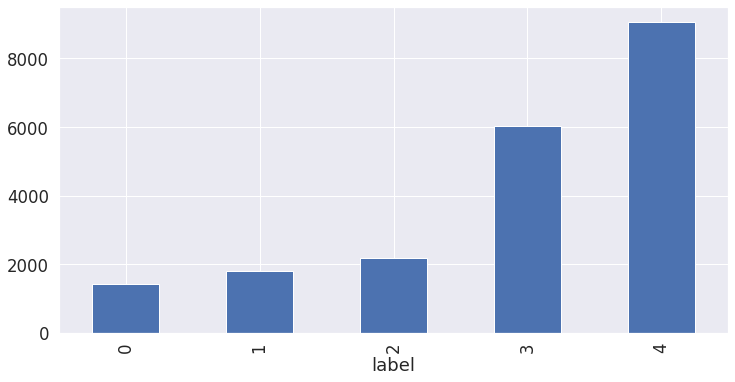

In [ ]:
df.groupby("label").size().plot.bar()

Data is imbalance, let's calculate the class_weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(df.label), y= df.label)
class_weights

array([2.88402533, 2.28566648, 1.8764652 , 0.67862229, 0.45263972])

## Dataset class

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [label for label in df['label']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Split training-test dataset



In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

16392 2049 2050


## Model building


Now comes to the most important part of this notebook. We need to buid a classifier model on top of a pre-trained GPT-2 model. The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals our number of labels. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

For more information about how to build customized models in PyTorch, see [here](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

In [ ]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        #print("batch_size ",batch_size) to check the batch size
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Training loop


Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following [this guide](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Since this is a multi-class classification problem, I picked [cross-entropy-loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function ("criterion"), and [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as the optimization algorithm.

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

## Evaluation

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_val)

Test Accuracy:  0.645


In [ ]:
print(classification_report(true_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.74      0.57      0.64       157
           1       0.40      0.62      0.49       141
           2       0.57      0.16      0.25       217
           3       0.53      0.67      0.59       609
           4       0.80      0.76      0.78       925

    accuracy                           0.64      2049
   macro avg       0.61      0.56      0.55      2049
weighted avg       0.66      0.64      0.64      2049



In [ ]:
true_labels, pred_labels = evaluate(model, df_test)
print(classification_report(true_labels,pred_labels))

Test Accuracy:  0.640
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       157
           1       0.46      0.59      0.51       193
           2       0.59      0.18      0.27       226
           3       0.54      0.67      0.60       610
           4       0.79      0.75      0.77       864

    accuracy                           0.64      2050
   macro avg       0.61      0.57      0.56      2050
weighted avg       0.65      0.64      0.63      2050



In [ ]:
print(f1_score(true_labels,pred_labels,average='micro'))

0.6404878048780488


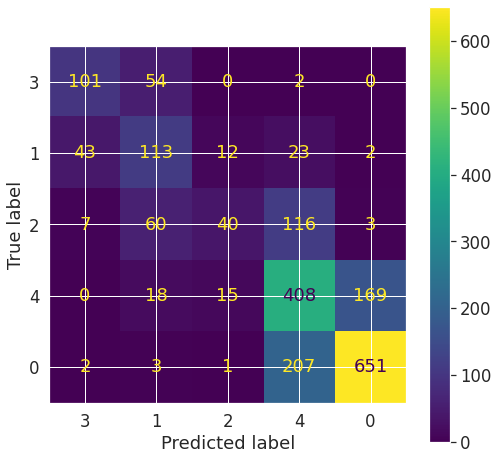

In [ ]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(df.label.unique())))#, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(df.label.unique()))
disp.plot(ax=ax)

## Saving and loading the model

In [ ]:
# save trained model
torch.save(model.state_dict(), "gpt2-text-classifier-model.pt")

In [ ]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("gpt2-text-classifier-model.pt"))
model_new.eval()

## Model Inference

In [ ]:
df.text.iloc[5], df.label.iloc[5]

In [ ]:
example_text = df.text.iloc[5]
fixed_text = " ".join(example_text.lower().split())
print(fixed_text)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(fixed_text, padding='max_length', max_length=128, truncation=True, return_tensors="pt")

In [ ]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)
print("output ", output)
prob = torch.nn.functional.softmax(output, dim=1)[0]
print("prob ", prob)
pred_label = prob.argmax()
print("pred_label ", pred_label)

# Models Comparison

\begin{array}{ccc}
&Bert&Bert(clsImb)&DistillBert&Albert&Roberta&XLNet&GPT2\\
Epochs&4&1&1&1&1&1&1\\
BatchSize&32&8&8&8&8&8&2\\
LearnRate&2*10^{-5}&4*10^{-5}&4*10^{-5}&4*10^{-5}&4*10^{-5}&4*10^{-5}&10^{-5}&\\
F1ScoreEval&0.646&0.65&0.64&0.57&0.49&0.64&0.64\\
F1ScoreTest&0.646&0.667&0.64&0.58&0.51&0.66&0.64\\
TrainTime&5min&4min&2min&3min&4min&5min&14 min
\end{array}

From above table, we can say that, Bert(clsImb) and XLNet are best. I have trained for one epoch only just to avoid the colab memory and limited runtime limitation. The above results might varry for higher epochs and tunning of other parameters. 